In [11]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

LOAD DATA SET

In [12]:
historical_file_path = "historical_quiz_data.json"
submission_file_path = "quiz_submission_data.json"
current_quiz_file_path = "data.json"

with open(historical_file_path, "r") as file:
    historical_data = json.load(file)

with open(submission_file_path, "r") as file:
    submission_data = json.load(file)

with open(current_quiz_file_path, "r") as file:
    current_quiz_data = json.load(file)

Normalize historical quiz data, quiz submission data,current quiz data

In [13]:
historical_quizzes = pd.json_normalize(historical_data)

In [15]:
latest_quiz = pd.json_normalize(submission_data)
current_quiz = pd.json_normalize(current_quiz_data["quiz"]["questions"])


Extract response map columns dynamically

In [17]:
response_map_columns_historical = [
    col for col in historical_quizzes.columns if col.startswith("response_map")
]
response_map_columns_latest = [
    col for col in latest_quiz.columns if col.startswith("response_map")
]


select relevnt column

In [19]:
historical_relevant = historical_quizzes[
    [
        "quiz.title",
        "quiz.topic",
        "score",
        "accuracy",
        "final_score",
        "correct_answers",
        "incorrect_answers",
    ]
    + response_map_columns_historical
]

latest_relevant = latest_quiz[
    [
        "quiz.title",
        "quiz.topic",
        "score",
        "accuracy",
        "final_score",
        "correct_answers",
        "incorrect_answers",
    ]
    + response_map_columns_latest
]


Combine dataset

In [22]:
combined_data = pd.concat([historical_relevant, latest_relevant], ignore_index=True)

analyze performance by topic

In [23]:
performance_by_topic = combined_data.groupby("quiz.topic").agg(
    {
        "score": "mean",
        "accuracy": lambda x: pd.to_numeric(x.str.rstrip("%")).mean(),
        "correct_answers": "sum",
        "incorrect_answers": "sum",
    }
).reset_index()


# Include analysis of current quiz data

In [26]:
weak_topics = performance_by_topic[
    (performance_by_topic["accuracy"] < 50) | (performance_by_topic["incorrect_answers"] > 5)
]

In [27]:
strong_topics = performance_by_topic[
    (performance_by_topic["accuracy"] > 80) & (performance_by_topic["correct_answers"] > 10)]

In [28]:
recommendations = []
for index, row in weak_topics.iterrows():
    recommendations.append(
        f"Focus on improving the topic '{row['quiz.topic']}' where your accuracy is {row['accuracy']:.2f}%."
    )
for index, row in strong_topics.iterrows():
    recommendations.append(
        f"Continue practicing '{row['quiz.topic']}' as it is your strong area with {row['accuracy']:.2f}% accuracy."
    )

In [29]:
print("Weak Areas:")
print(weak_topics)
print("\nStrong Areas:")
print(strong_topics)
print("\nRecommendations:")
for recommendation in recommendations:
    print("- " + recommendation)

Weak Areas:
                                 quiz.topic      score   accuracy  \
0               Body Fluids and Circulation  86.666667  72.333333   
1              Body Fluids and Circulation   54.666667  80.000000   
2                        Human Reproduction  40.000000  38.000000   
3                       Reproductive Health  52.000000  43.000000   
8  principles of inheritance and variation   12.000000  30.000000   

   correct_answers  incorrect_answers  
0               65                 24  
1               41                 10  
2               10                 16  
3               13                 17  
8                3                  7  

Strong Areas:
                  quiz.topic  score  accuracy  correct_answers  \
6  human health and disease   112.0      93.0               28   
7  microbes in human welfare   76.0     100.0               19   
9       reproductive health    52.0      92.0               26   

   incorrect_answers  
6                  2  
7      

In [30]:
insights_path = "quiz_insights_and_recommendations.csv"
performance_by_topic.to_csv(insights_path, index=False)
print(f"\nInsights and recommendations saved to {insights_path}.")


Insights and recommendations saved to quiz_insights_and_recommendations.csv.


<ipython-input-31-e035a15c4b10>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


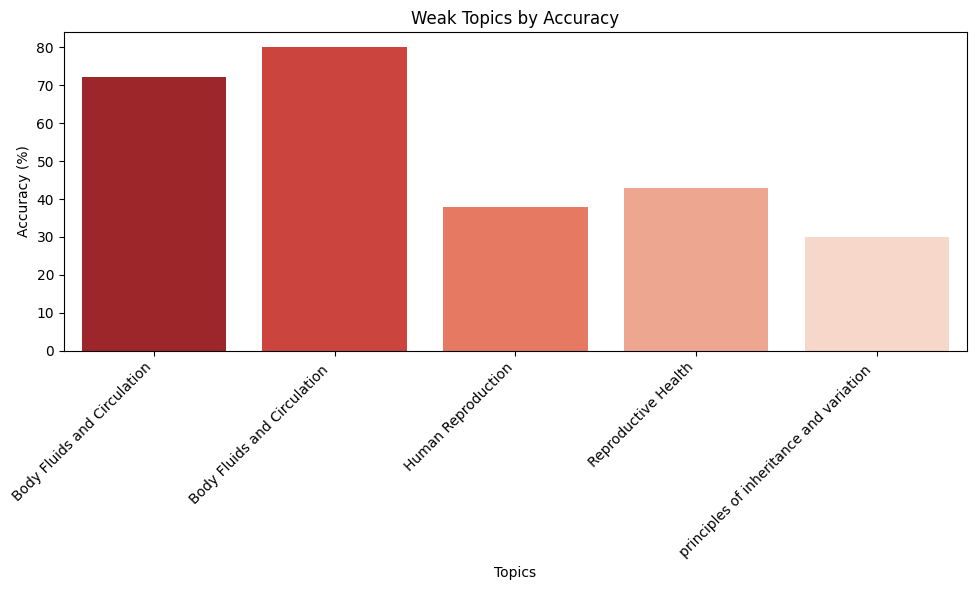

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=weak_topics,
    x="quiz.topic",
    y="accuracy",
    palette="Reds_r"
)
plt.title("Weak Topics by Accuracy")
plt.xlabel("Topics")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("weak_topics_visualization.png")
plt.show()

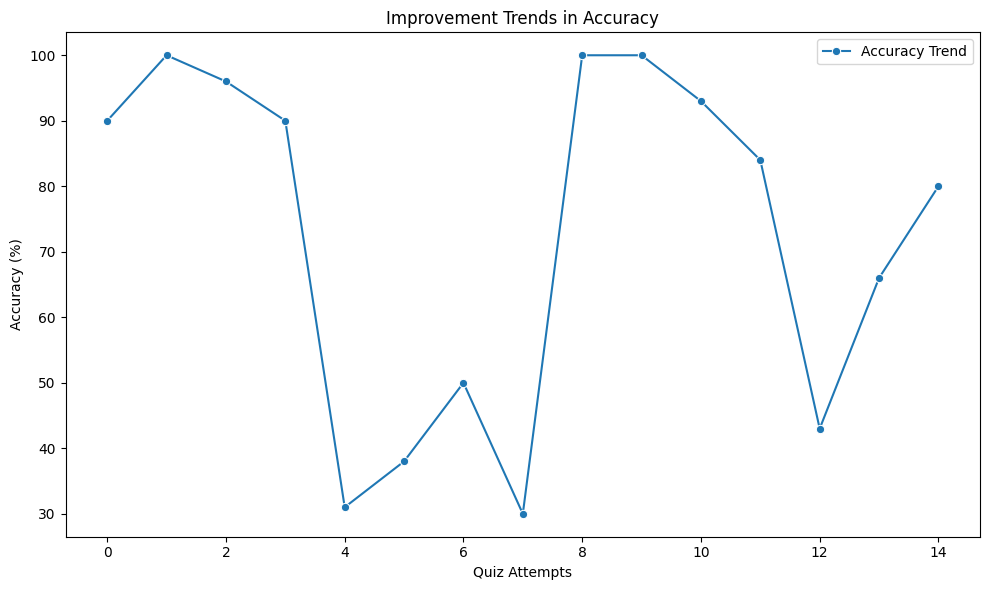

In [32]:
combined_data["accuracy_numeric"] = combined_data["accuracy"].str.rstrip("%").astype(float)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=combined_data,
    x=combined_data.index,
    y="accuracy_numeric",
    marker="o",
    label="Accuracy Trend"
)
plt.title("Improvement Trends in Accuracy")
plt.xlabel("Quiz Attempts")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.savefig("improvement_trends.png")
plt.show()


<ipython-input-33-78477b4e2348>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


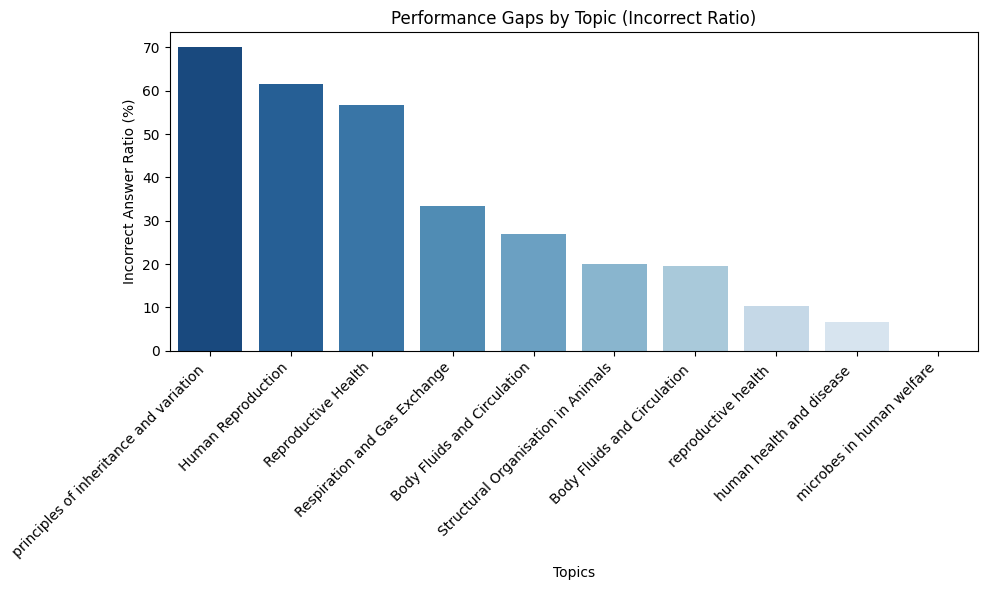

Visualizations saved as images.


In [33]:
performance_by_topic["incorrect_ratio"] = (
    performance_by_topic["incorrect_answers"] /
    (performance_by_topic["correct_answers"] + performance_by_topic["incorrect_answers"])
) * 100

plt.figure(figsize=(10, 6))
sns.barplot(
    data=performance_by_topic.sort_values("incorrect_ratio", ascending=False),
    x="quiz.topic",
    y="incorrect_ratio",
    palette="Blues_r"
)
plt.title("Performance Gaps by Topic (Incorrect Ratio)")
plt.xlabel("Topics")
plt.ylabel("Incorrect Answer Ratio (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("performance_gaps.png")
plt.show()

print("Visualizations saved as images.")
